# Comic relief

![img](//s-media-cache-ak0.pinimg.com/564x/53/97/9f/53979fcd941669007f59c5cdb1317b27.jpg)

# Parameter estimation from differential equation based models

In the last few lectures, we considered linear and nonlinear regression of analytical models to data. In some cases, we had to transform the data to do this, e.g. by taking numerical derivatives. We observed that numerical differentiation enhances noise in the data, especially at the endpoints, where a less accurate estimate for the derivative is used.
Today, we consider regression with the integration of differential equations. Recall that when we integrate an ODE, we get a *numerical solution* to the function we are interested in. So, if we were vary the parameters in the model to get the solution that best fit the data, we would have performed our goal.
Let's briefly review what our solvers can do. Suppose we have the ODE $\frac{df}{dx}=-4$ with $f(0) = 1$.
We can get the solution to this ODE at *any x-values* we choose.

In [3]:
import numpy as np
from scipy.integrate import odeint

def ode(f, x):
    return -4

f0 = 1 # initial conditions
xspan = np.array([0, 0.2, 0.5, 0.8]) # You choose the xspan

sol = odeint(ode, f0, xspan)
print(sol)
print(1 - 4 * xspan)

[[ 1. ]
 [ 0.2]
 [-1. ]
 [-2.2]]
[ 1.   0.2 -1.  -2.2]


Now, suppose we are given this data, and we believe it should be modeled by an equation that looks like $y = m x + b$.

In [5]:
import numpy as np
x = np.array([0, 1, 2, 4])
y = np.array([1, 3, 5, 9])

Probably by inspection you can see that $m=2$ and $b=1$. Let's consider how to use the idea of an ODE to explore this.

$y'(x) = m$ we can express our model as $y(0) = 1$.

In this block, we can vary $m$ and $b$ and see for what pair of them do we get the best agreement with the y-data listed above.

In [14]:
m, b = 2., 1 # Try varying these

def ode(f, x):
    return m

y0 = b
xspan = x

sol = odeint(ode, y0, xspan)
print(sol)
print('Error = {}'.format(sol[:, 0] - y))

[[ 1.]
 [ 3.]
 [ 5.]
 [ 9.]]
Error = [ 0.  0.  0.  0.]


We can wrap this in a regression problem like this.

In [24]:
from pycse import  nlinfit

def model(xx, m, b):
    print(xx, m , b)
    y0 = b
    def ode(f, xx):
        return m
    yy = odeint(ode, y0, xx)
    return yy[:, 0] # We have to return a 1D array

guess = [1, 1]
p, pint, se = nlinfit(model, x, y, guess, alpha=0.05)
print('p = ',p)
print('pint = ',pint)

[0 1 2 4] 1 1
[0 1 2 4] 1.0 1.0
[0 1 2 4] 1.0 1.0
[0 1 2 4] 1.0000000149 1.0
[0 1 2 4] 1.0 1.0000000149
[0 1 2 4] 1.99999993869 1.00000004768
[0 1 2 4] 1.9999999685 1.00000004768
[0 1 2 4] 1.99999993869 1.00000006258
[0 1 2 4] 2.0 1.0
[0 1 2 4] 2.0000000298 1.0
[0 1 2 4] 2.0 1.0000000149
[0 1 2 4] 2.0 1.0
p =  [ 2.  1.]
pint =  [[ 2.  2.]
 [ 1.  1.]]


## Application to mole balances

Recall that we used regression on mole balances, but that we had to numerically compute derivatives. We can use the approach above to fit the mole balance directly. Suppose we have this mole balance and some data, and we want to estimate $k$ and $\alpha$.
$$\frac{dC_A}{dt} = -k C_A^\alpha$$
The strategy is to guess values for $k$ and $\alpha$ until we find the pair that best matches the data. We use nlinfit to vary the parameters and "fit" the data. Here is the setup.

In [29]:
t = np.array([0, 50, 100, 150, 200, 250, 300]) # min
Ca = np.array([0.05, 0.038, 0.0306, 0.0256, 0.0222, 0.0195, 0.0174]) # mol/L

Ca0 = 0.05

def dCadt(Ca, t, k, alpha):
    return -k * Ca**alpha

def model(t, k, alpha):
    Ca = odeint(dCadt, Ca0, t, args=(k, alpha))
    return Ca[:,0]  # must return a 1D array here

guess = [0.1, 2.0] # from the linear regression

p, pint, se = nlinfit(model, t, Ca, guess, 0.05)

k_range, alpha_range = np.array(pint)

print(p, np.mean(pint, axis=1))
print('alpha = {} at the 95% confidence level'.format(alpha_range))
print('k = {0} at the 95% confidence level'.format(k_range))

[ 0.14267145  2.03663555] [ 0.14267145  2.03663555]
alpha = [ 2.00235724  2.07091387] at the 95% confidence level
k = [ 0.12596679  0.15937611] at the 95% confidence level


As always, we should evaluate the quality of our fit visually. Here you can see the fit is quite good.

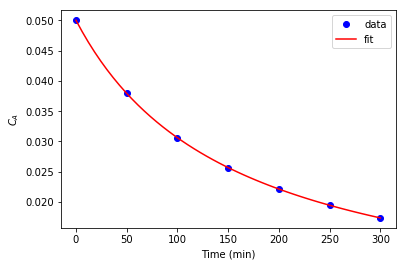

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(t, Ca, 'bo ')

tfit = np.linspace(0, 300)

k, alpha = p

plt.plot(tfit, model(tfit, k, alpha), 'r-')
plt.xlabel('Time (min)')
plt.ylabel('$C_A$')
plt.legend(['data', 'fit'])

In [31]:
t
model(t, *p)

array([ 0.05      ,  0.03793865,  0.03061811,  0.02569509,  0.02215395,
        0.01948253,  0.0173943 ])

The confidence intervals here are identical to the nonlinear fit to the analytical solution!  We have essentially solved the same fitting problem, but without the need for the analytical solution. Notice again that initial guesses were required; this is still nonlinear regression.

# Effects of uncertainty on reactor design

The effects of uncertainty in parameters on design are a result of propagation of errors.
If there is uncertainty in a number, and that number is used to calculate another number, then the result will have uncertainty also.
We can quantitatively determine the uncertainty and how it is propagated (see [propagation of uncertainty](http://en.wikipedia.org/wiki/Propagation_of_uncertainty)).
If a function depends on parameters (a, b, c &#x2026;) that have corresponding uncertainties ($\sigma_a$, $\sigma_b$, $\sigma_c$,&#x2026;) then the uncertainty in $f$ is approximately:
$s_f = \sqrt{\left( \frac{\partial f}{\partial a}\right)^2 s_a^2 + \left( \frac{\partial f}{\partial b}\right)^2 s_b^2  + \left( \frac{\partial f}{\partial c}\right)^2 s_c^2 + \cdots}  $

-   Consider we have a parameter $k=0.1$ 1/s with standard error of &sigma;<sub>k</sub> = 0.02, i.e. $k = 0.1 \pm 0.02$ 1/s.
-   If the rate law is $r = k C_A$, and there is no uncertainty in $C_A$, what is the uncertainty in the rate for $C_A=2$?

$ \sigma_r = \sqrt{\left(\frac{\partial r}{\partial k}\right)^2\sigma_k^2} $

-   Evaluating this leads to &sigma;<sub>r</sub> = C<sub>A</sub> &sigma;<sub>k</sub> = 0.04
-   In other words, the rate will be 0.2 &plusmn; 0.04 mol/L/s
-   It can be tedious to evaluate all of the partial derivatives
-   The `uncertainties` package can help tremendously for this

[uncertainties](https://www.google.com/#safe=off&q=uncertainties)

In [40]:
!pip install uncertainties

In [45]:
import uncertainties as u

k = u.ufloat(0.1, 0.02)
CA = u.ufloat(20, 5)

print('The rate is {0} mol/L/s'.format(k * CA))

# print(np.sin(k)) does not work
# print(np.exp(k))
# Only works on regular algebra
print(k**0.5)
print(1 / k)

The rate is 2.0+/-0.6 mol/L/s
0.316+/-0.032
10.0+/-2.0


-   `uncertainties` automatically propagates most errors through all standard math operations, and many (but not all) functions. For example, you cannot use it out of the box with fsolve or odeint.

## Error propagation by Monte Carlo simulation

An alternative approach to error propagation is Monte Carlo simulation. In this approach we sample the variables with uncertainty and perform the calculations many times. Then we use statistical analysis to determine the uncertainty of the result.  We illustrate the approach on estimating the uncertainty here.
First, some new ideas. We can generate a distribution of values with particular statistical properties. Recall that when we say the average value of $k$ is 0.1 with a standard deviation of 0.02, we mean that measurements of $k$ follow a Normal distribution with those properties.

The average k = 0.10
The std dev k = 0.02
0.9553


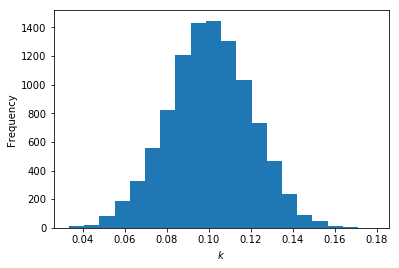

In [48]:
N = 10000
muk = 0.1
sigmak = 0.02
k = np.random.normal(muk, sigmak, N)

print('The average k = {:1.2f}'.format(np.mean(k)))
print('The std dev k = {:1.2f}'.format(np.std(k)))

plt.hist(k, 20)
plt.xlabel('$k$')
plt.ylabel('Frequency')

print(np.sum((k > 0.06) & (k < 0.14)) / N)

We can use this to do propagation of errors.

The average rate is 0.2007497643918794 mol/L/s
The standard error is 0.03959340335088722 mol/L/s


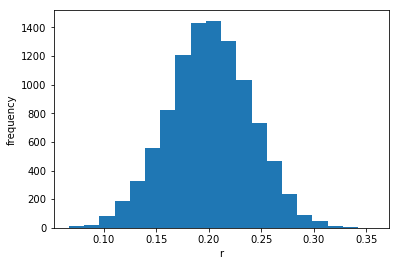

In [51]:
CA = 2.0

r = k * CA
print('The average rate is {0} mol/L/s'.format(np.mean(r)))
print('The standard error is {0} mol/L/s'.format(np.std(r)))

plt.hist(r, 20)
plt.xlabel('r')
plt.ylabel('frequency')

You can see that the distribution appears approximately normally distributed. The average is approximately the same as we observed in the previous two approaches. The standard error is also approximately the same.

This approach makes no assumptions about the error propagation other than errors in the parameters are not correlated. We do assume the uncertainty in the parameters is normally distributed.

Note it is possible with the normal distribution for $k$ to be negative. This is not physically meaningful. The probability of that happening is very low. $k$ is only approximately normally distributed about the mean, not in the tails.

## An application in reactor design

Let us illustrate the effects of uncertainty on the exit concentration of a CSTR.

-   $r_A = k C_A^2$ with $k$ = 3.0 &plusmn; 0.2 L/mol/hr
-   $A$ is fed to the reactor at a rate of 5 &plusmn; 0.05 mol/hr
-   The volumetric flow is 10 &plusmn; 0.1 L/hr
-   The reactor volume is 66000 L

What is the exit concentration? What is the probability the exit concentration exceeds 0.05 M?

-   We have to solve $0 = F_{A,in} - F_{A,out} + r_A V$
-   We have several variables to create distributions for. We will create all the samples, and then loop through them and store the result in a vector.

We can easily find the number of elements in an array that meet some criteria, e.g. are greater than some number like this.

In [54]:
import numpy as np
a = np.array([1, 2, 3, 4])

print((a > 2).sum())

2


We will be smart here and recognize that we can use the quadratic formula to solve the mole balance. This will let us leverage the use of vectorized calculations with numpy arrays.

$-V k C_A^2 - \nu_0 C_A + F_{A0} = 0$

Here we define: $a = - V k$, $b=\nu_0$ and $c = F_{A0}$
so:

$C_A = \frac{-b - \sqrt{b^2 - 4 a c}}{2 a}$

Ca(exit) = 0.004527214470751605+/-0.00015608555092607153
Probability that the exit concentration is greater than 0.005M is 0.0035


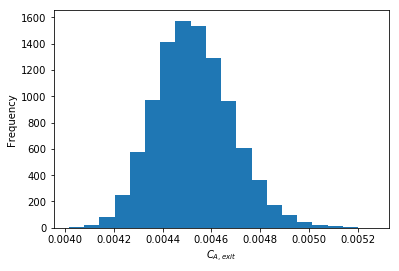

In [68]:
N = 10000    # number of MC samples
V =  66000   # L

Fa0 = np.random.normal(4, 0.05, N)
v0 = np.random.normal(10, 0.1, N)
k = np.random.normal(3., 0.2, N)

a = -V * k
b = v0
c = Fa0

Ca = (-b - np.sqrt(b**2 - 4 * a * c)) / (2 * a)

print('Ca(exit) = {0}+/-{1}'.format(np.mean(Ca), np.std(Ca)))

plt.hist(Ca, 20)
plt.xlabel('$C_{A, exit}$')
plt.ylabel('Frequency')

print('Probability that the exit concentration is greater than 0.005M is {}'.format((Ca > 0.005).sum() / len(Ca)))

This analysis shows there is a few percent uncertainty in the exit concentration.

In [1]:
print(np.std(Ca) / np.mean(Ca) * 100)

3.37942590525

That may be acceptable. Note that the distribution is not exactly normal, but it is close. Note that if 0.005 M was a target goal though, there is a good probability you will not meet it due to the uncertainty.

It is not fast to do Monte Carlo. You need many calculations to get good statistics. If each one involves fsolve, or odeint, it can be expensive to run, and in some cases you may find not all calculations converge. Still, it is in some cases easier than propagating errors by hand.

# Reminder

The exam will take place on Wednesday. **There will be no class on Wed.**
Problems will be assigned at 9am on Wednesday and collected at 9am on Thursday. I strongly encourage you to work on the problems during the scheduled class time so you can ask me questions while I am in the building. I will not be up all night to answer questions ;)
I anticipate you will be able to finish the exam during the scheduled class time, assuming you know what to do and do not spend a lot of time looking for examples.
You must work alone on your exam.